In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.utils.data as Data
import torchvision.transforms as T
from glob import glob
import os
import cv2
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchvision.utils import save_image
import pandas as pd
import time
import pickle
import math
%matplotlib inline

In [2]:
class Parser():
    #hyperparameters
    def __init__(self):
        self.n_batch_train = 64 
        self.n_batch_test = 64 
        self.fmap = 1
        self.pmap = 16
        self.dal = 1
        self.n_batch_init = 256
        self.lr = 0.001
        self.polyak_epochs = 1
        self.epochs_warmup = 10
        self.anchor_size = 32
        self.n_levels = 3
        self.n_sample = 1
        self.n_channel = 1
        self.n_epoch = 5
        self.flow_permutation = 2
        self.flow_coupling = 0
        self.image_size = 32
        self.n_bits_x = 8
        self.depth = 32
        self.dim = 128
        self.y_dim = 10
        self.n_y= 10
        self.batch_size = 5
        self.learntop = True
        self.ycond = True
        self.weight_y = 0.5
hps = Parser()  
hps.n_bins = 2. ** hps.n_bits_x

In [3]:


to_img= T.Compose([T.ToPILImage()])
to_tensor = T.Compose([T.ToTensor()])
load_norm = T.Compose([T.Resize((hps.image_size,hps.image_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 

In [4]:
def checkpoint(z, logdet):
    zshape = z.size()
    z = z.view(-1,zshape[1]*zshape[2]*zshape[3])
    logdet = logdet.view(-1,1)
    combined = torch.cat([z, logdet], dim = 1)
    logdet = combined[:, -1] # Why do we omit the last one?
    z = combined[:, :-1].view(-1, zshape[1], zshape[2], zshape[3])
    return z, logdet

def squeeze2d(x, factor=2):
    assert factor >= 1
    if factor == 1:
        return x
    shape = x.size()
    height = int(shape[2])
    width = int(shape[3])
    n_channels = int(shape[1])
    assert height % factor == 0 and width % factor == 0
    x = x.view( [-1, n_channels, height//factor, factor,
                       width//factor, factor ])
    x = x.permute([0, 1, 3, 5, 2, 4])
    x = x.contiguous().view([-1, n_channels*factor*factor,height//factor, width //factor])
    return x

def unsqueeze2d(x, factor=2):
    assert factor >= 1
    if factor == 1:
        return x
    shape = x.size()
    height = int(shape[2])
    width = int(shape[3])
    n_channels = int(shape[1])
    assert n_channels >= 4 and n_channels % 4 == 0
    x = x.view(-1, int(n_channels/(factor**2)), height, width, factor, factor)
    x = x.permute([0, 1, 4, 2, 5, 3])
    x = x.contiguous().view(-1, int(n_channels/(factor**2)),int(height*factor), int(width*factor))
    return x

def gaussian_diag(mean, logsd):
    class o(object):
        pass
    o.mean = mean
    o.logsd = logsd
    o.eps = torch.randn(mean.size())
    o.sample = mean + torch.exp(logsd) * o.eps
    o.sample2 = lambda eps: mean + torch.exp(logsd) * eps
    o.logps = lambda x: -0.5 * (torch.log(torch.tensor(2 * np.pi)) + 2. * logsd + (x - mean) ** 2 / torch.exp(2. * logsd))
    o.logp = lambda x: flatten_sum(o.logps(x))
    o.get_eps = lambda x: (x - mean) / torch.exp(logsd)
    return o

def flatten_sum(logps):
    if len(logps.size()) == 2:
        return logps.sum(1)
    elif len(logps.size()) == 4:
        return logps.sum(-1).sum(-1).sum(-1)
    else:
        raise Exception()
        
def preprocess(x):
    x = x.float()
    if hps.n_bits_x < 8:
        x = (x / 2 ** (8 - hps.n_bits_x)).int()
    x = x / hps.n_bins - .5
    return x

def same_pad(kernel_size):
    return math.ceil((kernel_size-1)/2)

In [5]:
class Actnorm(nn.Module):
    def __init__(self, scale = 1, logscale_factor = 3):
        super(Actnorm, self).__init__()
        
        self.scale = scale
        self.logscale_factor = logscale_factor
        
        
    def forward(self, x, logdet = None, reverse = False):
        self.reverse = reverse
        if not self.reverse:
            x = self.actnorm_center(x)
            x = self.actnorm_scale(x,logdet)
            if type(logdet) != type(None):
                x, logdet = x 
        else: 
            x = self.actnorm_scale(x, logdet)
            if type(logdet) != type(None):
                x, logdet = x
            x = self.actnorm_center(x)
        
        if type(logdet) != type(None):
            return x, logdet
        return x
    
    def actnorm_center(self,x):
        
        if len(x.size()) == 2:
            x_mean = x.mean(1, True)
            b = nn.Parameter(x_mean)
        if len(x.size()) == 4:
            x_mean = x.mean(1, True)
            b = nn.Parameter(x_mean)
            
        if not self.reverse:
            x += b
        else:
            x -= b 
                
        return x 
    
    def actnorm_scale(self,x, logdet= None, logscale_factor = 3):
        
        if len(x.size()) == 2:
            x_var = torch.mean(x**2,1, keepdim=True)
            logdet_factor = 1
            _shape = (1, x.size(1))

        elif len(x.size()) == 4:
            x_var = torch.mean(x**2,1, keepdim=True)
            logdet_factor = x.size(2)*x.size(3)
            _shape = (1, x.size(1), 1, 1)
            
        logs = nn.Parameter(torch.log(self.scale/(torch.sqrt(x_var)+1e-6))/logscale_factor)*logscale_factor
        
        if not self.reverse:
            x = x * logs.exp()
        else:
            x = x * (-logs).exp()
            
        if type(logdet) != type(None):
            dlogdet = torch.mean(logs) * logdet_factor
            if self.reverse:
                dlogdet *= -1
            return x, logdet + dlogdet
        
        
        return x

In [6]:
class Invertible_1x1_conv(nn.Module):
    def __init__(self):
        super(Invertible_1x1_conv, self).__init__()
        self.init = True
        
        
    def forward(self, z , logdet, reverse=False):
        
        if self.init:
            self._def_model(z)
        
        dlogdet = torch.log(abs(torch.det(
                self.w))) * z.size(2)* z.size(3)
        
        if not reverse:
            z = F.conv2d(z, self.w.view(self.dim, self.dim, 1, 1), self.b)
            logdet += dlogdet
            
            return z, logdet
        
        else:
            z = z = F.conv2d(z, self.w.inverse().view(self.dim, self.dim, 1, 1), self.b)
            logdet += dlogdet
            
            return z, logdet
        
    def _def_model(self, z):
        self.dim = z.size(1)
        self.w = nn.Parameter(torch.tensor(np.linalg.qr(np.random.randn(self.dim, self.dim))[0].astype('float32')))
        self.b = nn.Parameter(torch.zeros(self.dim))
        self.init = False
        #print(self.__class__.__name__,' initialised')


In [7]:
class linear(nn.Module):
    def __init__(self, in_dim, out_dim, weightnorm =True, actnorm=True, scale=1.):
        super(linear, self).__init__()
        self.weightnorm = weightnorm
        self.actnorm = actnorm
        self.scale = scale
        self.l = nn.Linear(in_dim, out_dim)
        self.an = Actnorm(scale)
        
        
    def forward(self, x):
        
        if self.weightnorm:
            torch.nn.utils.clip_grad_norm_(self.l.parameters(),1,2)
        x = self.l(x)
        
        if self.actnorm:
            x = self.an(x)
        return x
    
class linear_zeros(nn.Module):
    def __init__(self, out_dim, logscale_factor = 3. ):
        super(linear_zeros, self).__init__()
        
        self.init = True
        self.out_dim = out_dim
        self.logscale_factor = logscale_factor
        
        
        
    def forward(self, x):
        if self.init:
            self._init_model(x)
        
        x = self.l(x)
        x *= torch.exp(self.logs)
        return x
    
    def _init_model(self,x):
        self.l = nn.Linear(x.size(1), self.out_dim)
        self.l.weight.data.fill_(0)
        self.l.bias.data.fill_(0)
        self.logs = nn.Parameter(torch.zeros(1,self.out_dim))* self.logscale_factor
        self.init = False

In [8]:
class f(nn.Module):
    def __init__(self, out_dim):
        super(f, self).__init__()
        self.model = nn.Sequential(
            Conv2dBlock(out_dim),
            nn.ReLU(inplace=True),
            Conv2dBlock(out_dim, 1),
            nn.ReLU(inplace=True),
            Conv2d_zerosBlock(out_dim),
        )
        
    def forward(self, h):
        
        return self.model(h)
            

        
class Conv2d_zerosBlock(nn.Module):
    def __init__(self, out_dim, kernel_size = 3, logscale_factor = 3 ):
        super(Conv2d_zerosBlock, self).__init__()
        
        self.out_dim = out_dim
        self.kernel_size = kernel_size
        self.logscale_factor = logscale_factor
        self.init = True
        
    def forward(self, x):
        
        if self.init:
            self._init_model(x)
        
        x = self.conv2d(x)
        x *= torch.exp(self.logs.expand_as(x))
        
        return x
    
    def _init_model(self, x):
        in_dim = x.size(1)
        p = same_pad(self.kernel_size)
        self.conv2d = nn.Conv2d(in_dim, self.out_dim , self.kernel_size ,1, p)
        self.logs = nn.Parameter(torch.zeros(1,self.out_dim, 1, 1)) * self.logscale_factor 
        nn.init.constant_(self.conv2d.weight,0)
        nn.init.constant_(self.conv2d.bias,0)
        self.init = False
        #print(self.__class__.__name__,' initialised')
        
class Conv2dBlock(nn.Module):
    def __init__(self, out_dim, kernel_size=3, weightnorm = False, actnorm = True):
        super(Conv2dBlock, self).__init__()
        self.weightnorm = weightnorm
        self.actnorm = actnorm
        self.k = kernel_size
        self.out= out_dim
        self.actnorm = Actnorm()
        
        self.init = True
        
    def forward(self, x):
        
        if self.init:
            self._init_model(x)
        
        if self.weightnorm:
            torch.nn.utils.clip_grad_norm_(self.conv2d.parameters(),1,2)
            
        x = self.conv2d(x)
        
        if self.actnorm:
            x = self.actnorm(x)
            
        return x
    
    def _init_model(self,x):
        self.in_dim = x.size(1)
        p = same_pad(self.k)
        self.conv2d = nn.Conv2d(self.in_dim, self.out, self.k, 1,p)
        self.init = False
        #print(self.__class__.__name__,' initialised')
        
        

In [9]:
class prior(nn.Module):
    def __init__(self):
        super(prior, self).__init__()
        self.n_z = hps.top_shape[0]
        
        self.conv2d = Conv2d_zerosBlock(2*self.n_z)
        self.linear = linear_zeros(2*self.n_z)
        
        
            
    def forward(self, y_onehot):
        
        h = torch.zeros([y_onehot.size(0)]+[2*self.n_z]+hps.top_shape[1:])
        if hps.learntop:
            h = self.conv2d(h)
        if hps.ycond:
            h += self.linear(y_onehot).view(-1,self.n_z*2, 1,1)
            
        pz = gaussian_diag(h[:,:self.n_z,:,:],h[:,self.n_z:,:,:])
        
        def logp(z1):
            objective = pz.logp(z1)
            return objective

        def sample(eps_std=None):
            if eps_std is not None:
                z = pz.sample2(pz.eps * eps_std.view([-1, 1, 1, 1]))
            else:
                z = pz.sample

            return z

        return logp, sample


In [10]:
class Split2d(nn.Module):
    def __init__(self):
        super(Split2d, self).__init__()
        '''
        dim -> 2 x dim
        '''
        
        self.init = True
        
    def forward(self, z, objective = 0., eps_std=None, reverse = False):
        
        if self.init:
            self._init_model(z)

        if not reverse:
            n_z = z.size(1)

            z1 = z[:, :n_z // 2, :, :]
            z2 = z[:, n_z // 2:, :, : ]
            pz = self.split2d_prior(z1)
            objective += pz.logp(z2)
            z1 = squeeze2d(z1)
            return z1, objective
        else:
            z1 = unsqueeze2d(z)
            #print(z1.shape)
            pz = self.split2d_prior(z1)
            z2 = pz.sample
            if type(eps_std) is not type(None):
                z2 = pz.sample2(pz.eps * eps_std.view([-1, 1, 1, 1]))
            z = torch.cat([z1,z2],1)
            return z
                
    def split2d_prior(self, z):
        h = self.conv_zero(z)
        mean = h[:, 0::2, :, :]
        logs = h[:, 1::2, :, :]
        return gaussian_diag(mean, logs)

    def _init_model(self,z):
        self.conv_zero = Conv2d_zerosBlock(z.size(1))
        self.init = False
        

In [11]:
class RevNet_step(nn.Module):
    def __init__(self):
        super(RevNet_step, self).__init__()
        self.invertible1x1 = Invertible_1x1_conv()
        self.actnorm = Actnorm()
        self.init = True
        
        
    def forward(self, z, logdet, reverse=False):
        
        if self.init:
            self._init_model(z)
        
        if not reverse:
            
            z, logdet = self.actnorm(z, logdet)
            
            z, logdet = self.invertible1x1(z, logdet)
            z1 = z[:,:z.size(1)//2,:,:]
            z2 = z[:,z.size(1)//2:,:,:]
            
            z2 += self.ff(z1)
            
            
            z = torch.cat([z1,z2],1)
        
        else:
            
            z1 = z[:,:z.size(1)//2,:,:]
            z2 = z[:,z.size(1)//2:,:,:]
            
            z2 -= self.ff(z1)
            
            
            z = torch.cat([z1,z2],1)
            
            z, logdet = self.invertible1x1(z, logdet, True)
            
            z, logdet = self.actnorm(z, logdet, True)
            
        return z, logdet
    def _init_model(self,z):
        self.ff = f(z.size(1)//2)
        self.init = False
        #print(self.__class__.__name__,' initialised')
            

In [12]:
class RevNet2d(nn.Module):
    def __init__(self):
        super(RevNet2d, self).__init__()
        self.revnet2d_seq = nn.ModuleList()
        for i in range(hps.depth):
            self.revnet2d_seq.extend([RevNet_step()])
            
    def forward(self,z, logdet, reverse=False):
        
        if not reverse:
            for i,m in enumerate(self.revnet2d_seq):
                z, logdet = checkpoint(z , logdet)
                z, logdet = m(z, logdet, False)
            z, logdet = checkpoint(z, logdet)
            
        else: 
            for i,m in enumerate(reversed(self.revnet2d_seq)):
                z, logdet = m(z, logdet, True)
        
        return z, logdet
        
    


In [13]:
class Codec(nn.Module):
    def __init__(self):
        super(Codec, self).__init__()
        
        self.revnet_seq = nn.ModuleList()
        self.split2d_seq = nn.ModuleList()
        for i in range(hps.n_levels):
            self.revnet_seq.extend([RevNet2d()])


        for i in range(hps.n_levels-1):
            self.split2d_seq.extend([Split2d()])

    def forward(self,):
        raise NotImplementedError
        
    def encode(self, z, objective):
        
        for i in range(hps.n_levels):
            z, objective = self.revnet_seq[i](z, objective)
            if i < hps.n_levels - 1:
                z, objective = self.split2d_seq[i](z, objective)
        
        return z, objective
    
    def decode(self, z, eps_std):
        
        for i in reversed(range(hps.n_levels)):
            if i< hps.n_levels -1 :
                z = self.split2d_seq[i](z,eps_std=eps_std, reverse= True)
                #print(z.shape)
            z,_ = self.revnet_seq[i](z,0, reverse=True)
        return z
        

In [14]:
class _f_loss(nn.Module):
    def __init__(self):
        super(_f_loss, self).__init__()
        
        self.codec = Codec()
#         self.pr = prior()
        self.l_zero = linear_zeros(hps.n_y)
        self.sm = nn.CrossEntropyLoss()
        
        
    def forward(self, x,y, is_training=True):
    
        y_onehot = torch.zeros(y.size(0),hps.y_dim)
        #print(y.long().view(-1,1).shape, y_onehot.shape)
        y_onehot.scatter_(1, y.long().view(-1,1),1)

        objective = torch.zeros_like(x)[:,0,0,0]
        #z = preprocess(x)
        z = x
        z += torch.rand_like(z)

        objective += - torch.log(torch.tensor(hps.n_bins)) * (z[0].nelement())

        # Encode 

        z = squeeze2d(z, 2)
        z, objective = self.codec.encode(z, objective)
        hps.top_shape = list(z.size()[1:])


        # Prior
        try:
            logp, _ = self.pr(y_onehot)
        except:
            self.pr = prior()
            logp, _ = self.pr(y_onehot)
            
            
        objective += logp(z)
        
        # Generative loss
        
        nobj = - objective
        bits_x = nobj / torch.tensor((np.log(2.) * x[0].nelement()))#  bits per subpixel
                                     
                                     
        # Predictive loss
        if hps.weight_y > 0 and hps.ycond:

            # Classification loss
            h_y = z.sum(-1).sum(-1)
            y_logits = self.l_zero(h_y)

            bits_y = self.sm(y_logits, y.long())/torch.tensor(2.).log()
            

            # Classification accuracy
                                     
            y_predicted = torch.max(y_logits,dim = 1)[1].int()
            classification_error = 1 - (torch.eq(y_predicted, y.int())).float()
                                     
        else:
            bits_y = torch.zeros_like(bits_x)
            classification_error = torch.ones_like(bits_x)
        return bits_x, bits_y, classification_error
    
    def f_decode(self,y,eps_std):
        
        y_onehot = torch.zeros(y.size(0),hps.y_dim)
        y_onehot.scatter_(1, y.long().view(-1,1),1)
        
        _,sample = self.pr(y_onehot)
        z = sample(eps_std)
        
        z = self.codec.decode(z, eps_std)
        
        z = unsqueeze2d(z,2)
        
        #x = postprocess(z)
        
        return z
        
        
        

In [22]:
class Glow(nn.Module):
    def __init__(self):
        super(Glow, self).__init__()
        self.f = _f_loss() # hps.batch_size
        self.f(torch.ones(hps.batch_size,hps.n_channel,hps.image_size,hps.image_size),torch.ones(hps.batch_size),True) # pre_warm, the model 
        self.optim = optim.Adam(self.parameters(),lr = hps.lr)
        
    def forward(self,x,y,is_training=True):
        
        self.optim.zero_grad()
        bits_x, bits_y, pred_loss = self.f(x,y, is_training)
        local_loss = torch.mean(bits_x + hps.weight_y * bits_y)
        
        stats = [local_loss, bits_x, bits_y, pred_loss]
        self.global_stats = [torch.mean(i) for i in stats]
        
        local_loss.backward()
        self.optim.step()
        
    def sample(self, temperatures = [0.25]):
        #[0., .25, .5, .6, .7, .8, .9, 1.]
        x_sample = []
        rows = 10
        cols = rows
        n_batch = rows*cols
        y = np.asarray([_y % hps.n_y for _y in (
            list(range(cols)) * rows)], dtype='int32')
        for i in temperatures:
            x_sample.append(self.f.f_decode(torch.tensor(y),torch.tensor([i]*n_batch).float().detach()))
        return torch.stack(x_sample)



        
        
 
    
        

In [23]:
training_loader = DataLoader(datasets.MNIST('./data/mnist',train=True,
                    download=True,transform=load_norm),
                    batch_size=hps.batch_size, shuffle=True,drop_last=True)

In [24]:
g = Glow()
epoch = 0
all_steps = 1

In [18]:
scheduler = optim.lr_scheduler.StepLR(g.optim,10000,0.5)

| Step [1] | lr [0.0010] | L_Loss: [14.742] | X_Loss: [13.081] | Y_Loss: [3.322] | P_Loss: [1.000] | Time: 0.2s
| Step [2] | lr [0.0010] | L_Loss: [14.391] | X_Loss: [12.741] | Y_Loss: [3.300] | P_Loss: [0.800] | Time: 0.2s
| Step [3] | lr [0.0010] | L_Loss: [14.331] | X_Loss: [12.540] | Y_Loss: [3.582] | P_Loss: [1.000] | Time: 0.2s
| Step [4] | lr [0.0010] | L_Loss: [14.216] | X_Loss: [12.441] | Y_Loss: [3.551] | P_Loss: [1.000] | Time: 0.2s
| Step [5] | lr [0.0010] | L_Loss: [14.108] | X_Loss: [12.269] | Y_Loss: [3.677] | P_Loss: [1.000] | Time: 0.2s
| Step [6] | lr [0.0010] | L_Loss: [13.773] | X_Loss: [12.083] | Y_Loss: [3.380] | P_Loss: [1.000] | Time: 0.2s
| Step [7] | lr [0.0010] | L_Loss: [13.487] | X_Loss: [11.873] | Y_Loss: [3.228] | P_Loss: [0.800] | Time: 0.2s
| Step [8] | lr [0.0010] | L_Loss: [13.334] | X_Loss: [11.658] | Y_Loss: [3.352] | P_Loss: [1.000] | Time: 0.2s
| Step [9] | lr [0.0010] | L_Loss: [13.162] | X_Loss: [11.524] | Y_Loss: [3.275] | P_Loss: [1.000] | Tim

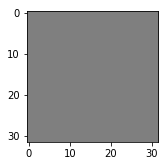

| Step [51] | lr [0.0010] | L_Loss: [8.489] | X_Loss: [6.818] | Y_Loss: [3.342] | P_Loss: [1.000] | Time: 0.2s
| Step [52] | lr [0.0010] | L_Loss: [8.388] | X_Loss: [6.739] | Y_Loss: [3.298] | P_Loss: [1.000] | Time: 0.2s
| Step [53] | lr [0.0010] | L_Loss: [8.359] | X_Loss: [6.652] | Y_Loss: [3.415] | P_Loss: [0.800] | Time: 0.2s
| Step [54] | lr [0.0010] | L_Loss: [8.270] | X_Loss: [6.590] | Y_Loss: [3.360] | P_Loss: [0.800] | Time: 0.2s
| Step [55] | lr [0.0010] | L_Loss: [8.091] | X_Loss: [6.472] | Y_Loss: [3.238] | P_Loss: [0.800] | Time: 0.2s


StopIteration: 

In [25]:
while epoch < hps.n_epoch:
    for i, (img, y) in enumerate(training_loader):    
        
        start_t = time.time()
        g(img,y,True)
        end_t = time.time()
        
#         scheduler.step()
        
        print('| Step [%d] | lr [%.4f] | L_Loss: [%.3f] | X_Loss: [%.3f] | Y_Loss: [%.3f] | P_Loss: [%.3f] | Time: %.1fs' %\
              ( all_steps, g.optim.param_groups[0]['lr'], g.global_stats[0].item(), g.global_stats[1].item(),
               g.global_stats[2].item(),g.global_stats[3].item(),
               end_t - start_t))


        if all_steps % 10 == 0: #args.show_freq
            fig=plt.figure(figsize=(8, 8))
            fig.add_subplot(1,3,1)
            plt.imshow(to_img(g.sample()[0][0].cpu()*0.5+0.5))
            plt.show()
#             if all_steps % args.img_save_freq ==0: # args.img_save_freq
#                 gan.image_save(all_steps)
#                 gan.plot_all_loss('Training')
#                 if all_steps % args.model_save_freq == 0: #args.model_save_freq
#                     gan.model_save(all_steps)
        all_steps += 1
        if all_steps > 55:
            raise StopIteration
    epoch +=1
